In [1]:
from ultralytics import YOLO

from typing import Dict, Union, Tuple, List, Optional
from collections import Counter
import os
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

Проверка GPU

In [2]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.211  Python-3.11.5 torch-2.1.1+cpu CPU (Intel Core(TM) i5-3470 3.20GHz)
Setup complete  (4 CPUs, 8.0 GB RAM, 125.5/431.0 GB disk)


In [3]:
import torch

cuda_flag = torch.cuda.is_available()
device = 'cuda' if cuda_flag else 'cpu'
device

'cpu'

Необходимые функции

In [4]:
def show_pred_img(preds: list, index_show: int) -> None:
    """Результат работы модели на одной картинке"""
    img = preds[index_show].plot()
    img = Image.fromarray(img[..., ::-1])
    # display(img)
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(img)


def softmax(x: list) -> float:
    """"""
    return np.exp(x) / sum(np.exp(x))


def _recalculation_dict_summator(summator: dict) -> dict:
    """Перерасчёт аналитического словаря в вероятностном виде."""
    conf_list = softmax(list(summator.values()))
    for i, key in enumerate(summator.keys()):
        summator[key] = conf_list[i]
    return summator


def analyse_target_class_by_count(
        classes: list,
        conf: list = None,
) -> tuple[Optional[str], Optional[float]]:
    """Обобщение класса изображения по наибольшему количеству.
    return:
        best_class: Optional[str] - самый вероятный класс.
        best_conf: Optional[float] - вероятность итогового класса."""
    summator = {}
    for i in range(len(classes)):

        name_class = str(classes[i])
        if name_class not in summator:
            summator[name_class] = 1
        else:
            summator[name_class] += 1

    summator = _recalculation_dict_summator(summator)
    best_class = max(summator, key=summator.get) if summator else None
    best_conf = summator.get(best_class, None)
    return (best_class, best_conf)

# Predict

In [37]:
model = YOLO('./weights/full_dataset_yolo8s_good/weights/full_dataset_yolo8s.pt')

# Данные для тестирования
PATH_TO_TEST_DATASET = 'test_dataset/video'

# Параметры для тестирования
COMPARE_BY_COUNT = True  # Сравнивать по количеству, иначе по conf(достоверности предсказания)
TEST_PARAMS = {
    'verbose': False,
    'conf': 0.25,  # порог достоверности обнаружения объекта, default=0.25
    'iou': 0.9,  # пересечение порога объединения (IOU), default=0.7
}

fps = 40
LEFT_FRAME_SEC = 10
RIGHT_FRAME_SEC = 15

target_filenames = []
target_classes = []
for index, filename in enumerate(os.listdir(PATH_TO_TEST_DATASET)):
    target_filenames.append(filename)
    new_path = os.path.join(PATH_TO_TEST_DATASET, filename)
    cap = cv2.VideoCapture(new_path)

    preds = []
    count_frame = 0
    classes = []
    while cap.isOpened():
        count_frame += 1

        time_now = count_frame / fps
        if LEFT_FRAME_SEC:
            if time_now < LEFT_FRAME_SEC:
                continue
        if RIGHT_FRAME_SEC:
            if time_now > RIGHT_FRAME_SEC:
                break

        # Считываем кадр
        success, frame = cap.read()
        if success:
            results = model.predict(frame, **TEST_PARAMS)
            result = results[0]
            preds.append(result)

            for i in result.boxes.cls:
                classes.append(model.names[int(i)])
        else:
            break  # Конец видео

    best_class, best_conf = analyse_target_class_by_count(classes)
    target_classes.append(best_class)

cap.release()
# cv2.destroyAllWindows()

In [38]:
df_submission = pd.DataFrame({'filenames': target_filenames, 'target': target_classes})
df_submission.to_csv('submission.csv', index=False, encoding="utf-8-sig")

df_submission.head()

filenames target
0  3654189_20sec.mp4  Грунт

#### Картинки

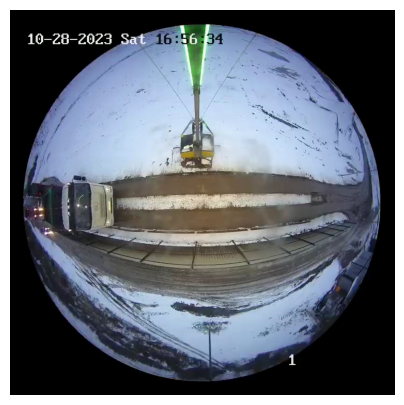

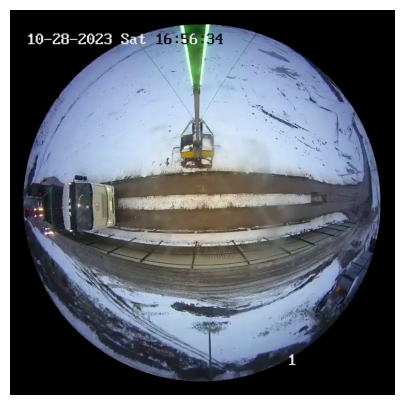

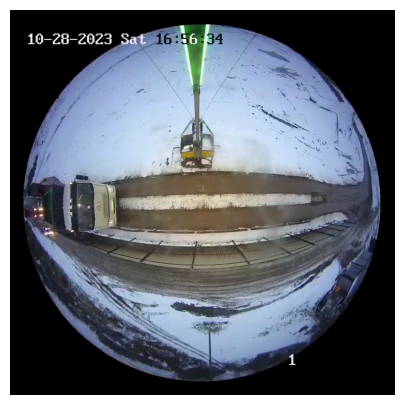

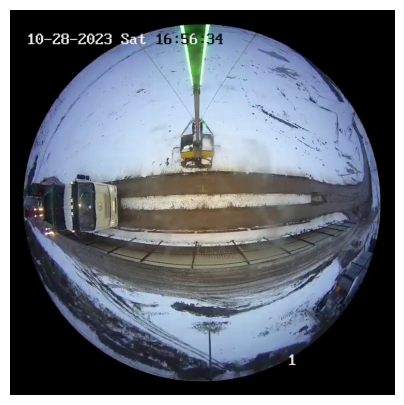

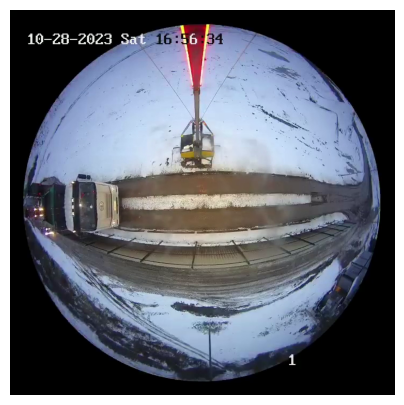

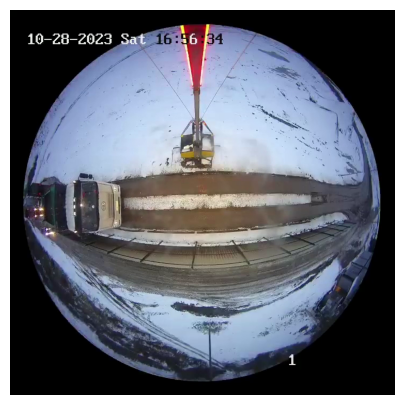

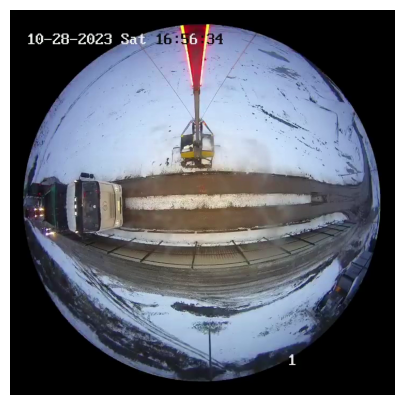

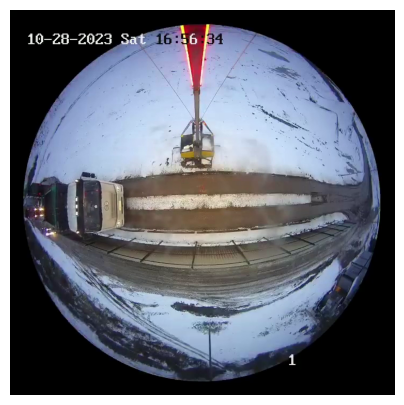

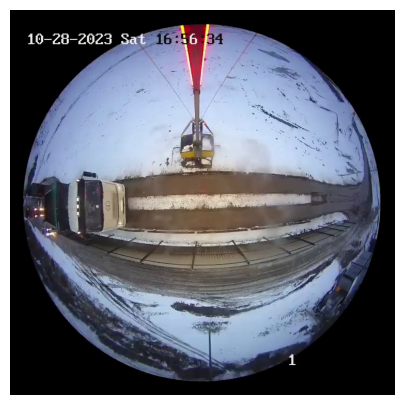

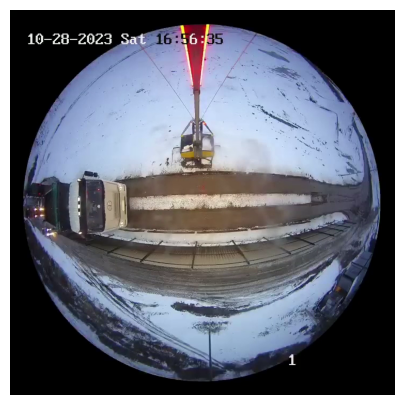

In [39]:
for i in range(0, 10):
    show_pred_img(preds, i)

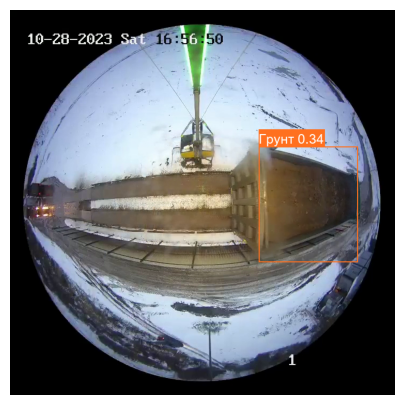

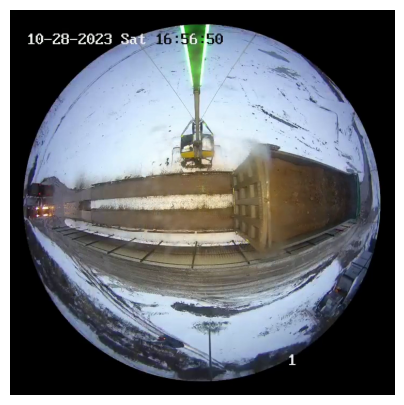

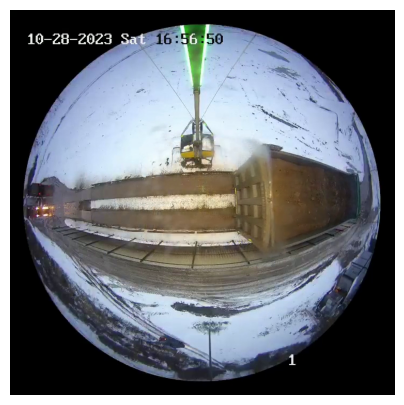

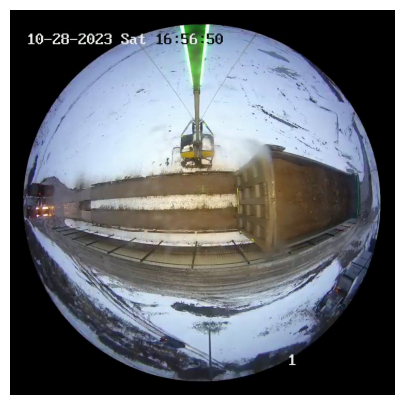

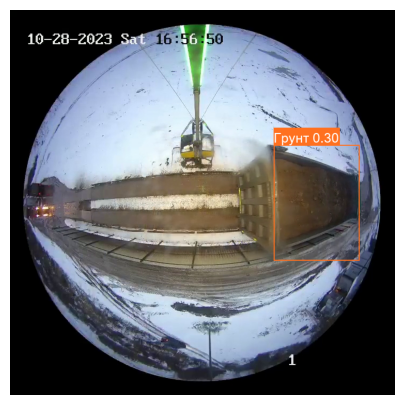

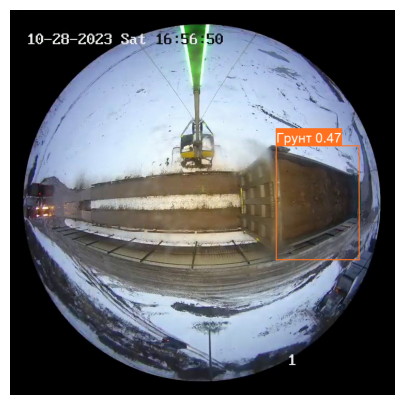

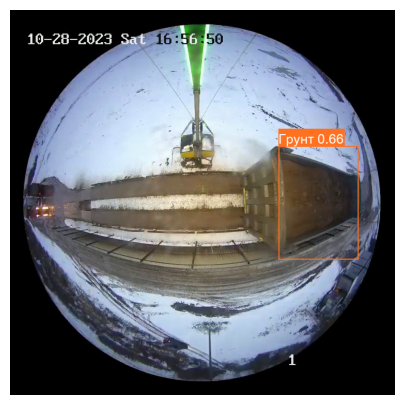

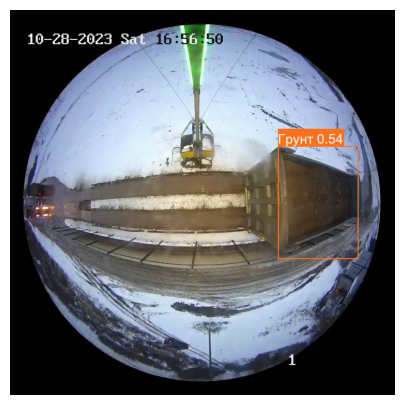

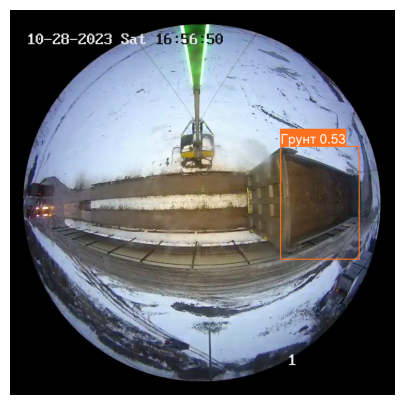

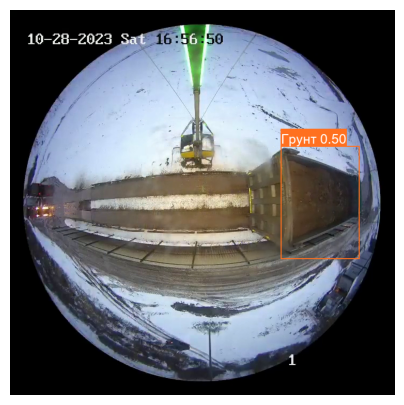

In [40]:
for i in range(len(preds)-10, len(preds)):
    show_pred_img(preds, i)

# Ensemble

In [ ]:
# from ensemble_boxes import *
# import cv2
# from random import randint


# def draw_boxes_from_list(path_to_image, boxes, labels, colors, names):
#     image = cv2.imread(path_to_image)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
#     height, width, _ = image.shape

#     for object_, label_ in zip(boxes, labels):
#         color = colors[int(label_ + 1)]
#         x_min, y_min, x_max, y_max = object_
#         x_min = int(x_min * width)
#         y_min = int(y_min * height)
#         x_max = int(x_max * width)
#         y_max = int(y_max * height)

#         image = cv2.putText(
#             image, names[int(label_)], (int(x_min), int(y_min - 10)),
#             fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
#             color=color, thickness=6,
#         )
#         image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=color, thickness=3)
#     return image


# def restructure_preds(yolo_pred):
#     """
#     Формирует предскзаания моделей в необходимом формате:
#     return:
#         (координаты bbox, уверенность в предсказаниях, предсказанные лейблы)
#     """
#     boxes_list, scores_list, labels_list = [], [], []
#     for object_ in yolo_pred[0].boxes:
#         boxes_list.extend(object_.xyxyn.tolist())
#         scores_list.extend(object_.conf.tolist())
#         labels_list.extend(object_.cls.tolist())
#     return boxes_list, scores_list, labels_list


# def ensemble_boxes(
#         models: List[YOLO],
#         path_to_image: str,
#         weights: Optional[List[float]] = None,
#         run_type: str = 'wbf',

#         iou_thr: float = 0.3,
#         skip_box_thr: float = 0.25,
# ):
#     """
#     Данная функция усредняет предсказания модели по боксам, исходя из ряда параметров

#     models: массив моделей, которые будут делать предсказание
#     path_to_image: путь до изображения для предсказания
#     weights: значимость каждой модели в ансамбле
#     run_type: тип усреднения
#     iou_thr: значение iou в совпадении полей
#     skip_box_thr: минимальная уверенность модели в предсказании
#     """
#     if weights is None:
#         weights = [1 for _ in range(len(models))]

#     boxes_, scores_, labels_ = [], [], []
#     for i, model in enumerate(models):
#         yolo_model_predict = model.predict(path_to_image, device=device, verbose=False, conf=skip_box_thr, iou=iou_thr)
#         boxes_list, scores_list, labels_list = restructure_preds(yolo_model_predict)

#         boxes_.append(boxes_list)
#         scores_.append(scores_list)
#         labels_.append(labels_list)
    
#     if run_type == 'wbf':
#         boxes, scores, labels = weighted_boxes_fusion(
#             boxes_,
#             scores_,
#             labels_,
#             weights=weights,
#             iou_thr=iou_thr,
#             skip_box_thr=skip_box_thr
#         )

#     elif run_type == 'non_maximum_weighted':
#         boxes, scores, labels = non_maximum_weighted(
#             boxes_,
#             scores_,
#             labels_,
#             weights=weights,
#             iou_thr=iou_thr,
#             skip_box_thr=skip_box_thr
#         )

#     else:
#         raise NotImplementedError(f"{run_type} type method for ensembling boxes is not implemented. Available "
#                                   f"methods: ['non_maximum_weighted', 'wbf']")
#     return boxes, scores, labels

In [ ]:
# model1 = YOLO('../weights/best.pt')
# model2 = YOLO('')

# models = [model1, ]
# weights = [1, ]

# COLORS = {name: [randint(0, 255),randint(0, 255),randint(0, 255)] for name in model1.names.keys()}
# NAMES = list(model1.names.values())

# for i, filename in enumerate(os.listdir(PATH_TO_TEST_DATASET)):
#     path = os.path.join(PATH_TO_TEST_DATASET, filename)
    
#     boxes, scores, labels = ensemble_boxes(
#         models=models,
#         path_to_image=path,
#         weights=weights,
#         run_type='wbf',  # ['non_maximum_weighted', 'wbf']
#         iou_thr=TEST_PARAMS['iou'],
#         skip_box_thr=TEST_PARAMS['conf'],
#     )

#     result_image = draw_boxes_from_list(
#         path_to_image=path,
#         boxes=boxes,
#         labels=labels,
#         colors=COLORS,
#         names=NAMES,
#     )

#     if i < 6:
#         plt.figure(figsize=(5, 5))
#         plt.axis('off')
#         plt.imshow(result_image)